In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Mix_dataset_3class.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset') 

In [ ]:
data_dir  = '/content/dataset/Mix_dataset_3class'
classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'plastic']


In [ ]:
quantity = []
for name in classes:
  quantity.append(len(os.listdir(data_dir + '/{}'.format(name))))
  #print(len(os.listdir(data_dir + '/{}'.format(name))), end= ' ')
print(quantity)

[1179, 2512, 1347]


In [ ]:
class_weights = pd.DataFrame({'Class': classes, 'Quantity': quantity})
class_weights['class_weight'] = class_weights.Quantity.sum() / (class_weights.shape[0] * class_weights.Quantity)
class_weights

,Class,Quantity,class_weight
0,metal,1179,1.424371
1,glass,2512,0.668524
2,plastic,1347,1.246721


In [ ]:
weights = class_weights['class_weight'].to_dict()
weights

{0: 1.4243709358213175, 1: 0.6685244161358811, 2: 1.2467211086364762}

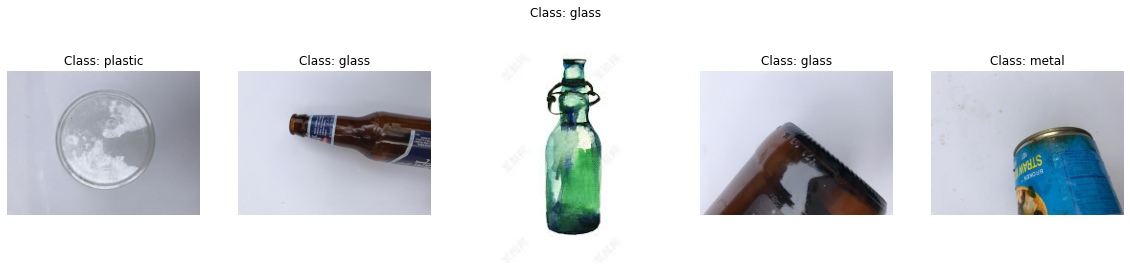

In [ ]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_garbage = random.choice(classes)
    random_image = random.choice(os.listdir(os.path.join(data_dir, random_garbage)))
    random_image_file = os.path.join(data_dir, random_garbage, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Class: " + random_garbage.replace('_', ' '))
    axes[i].axis('off')

plt.show() 

In [ ]:
import shutil 

train_dir = 'train'
test_dir = 'test'

for dir_name in [train_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in classes:
    source_dir = os.path.join(data_dir,  class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 10 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(test_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 1347/1347 [00:00<00:00, 10504.24it/s]


In [ ]:
for dir_name in [train_dir, test_dir]:
    for name in classes:
      print(len(os.listdir(dir_name + '/{}'.format(name))), end= ' ')

1061 2260 1212 118 252 135 

In [ ]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = len(classes)

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(directory='/content/test',
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    
                                                    shuffle=True,
                                                    classes=classes
                                                  )

train_generator = train_datagen.flow_from_directory(directory='/content/train',
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

valid_generator = train_datagen.flow_from_directory(directory='/content/train',
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID, "and", STEP_SIZE_TEST)

Found 505 images belonging to 3 classes.
Found 3627 images belonging to 3 classes.
Found 906 images belonging to 3 classes.
Total number of batches = 226 and 56 and 31


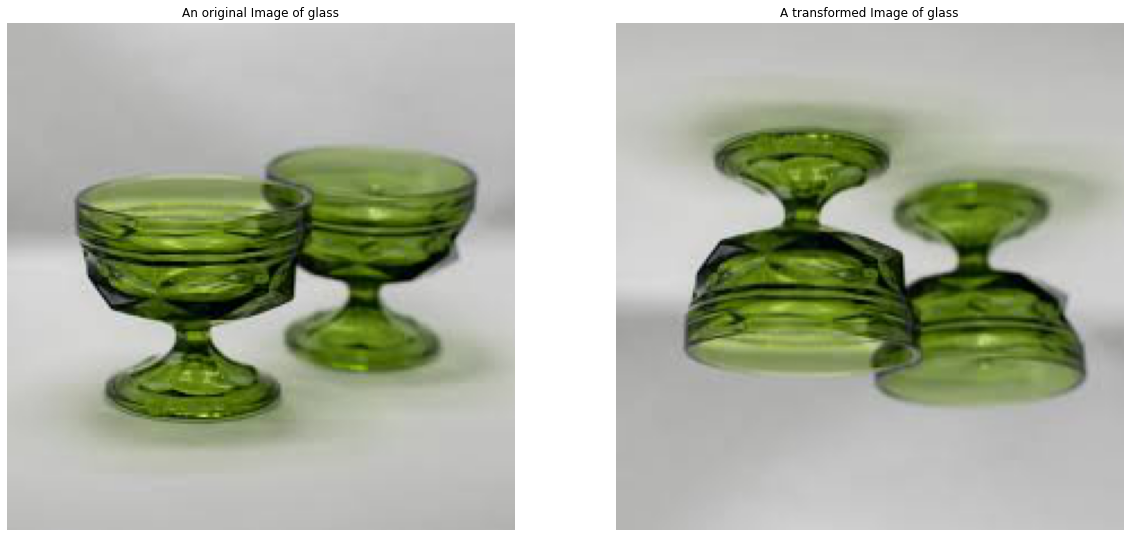

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_garbage = random.choice(classes)
random_image = random.choice(os.listdir(os.path.join('/content/test', random_garbage)))  
random_image_file = os.path.join('/content/test', random_garbage, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_garbage.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_garbage.replace('_', ' '))
axes[1].axis('off')

plt.show()

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(len(classes), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=weights
                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
226/226 [==============================] - 87s 293ms/step - loss: 0.4832 - accuracy: 0.8037 - val_loss: 1.1196 - val_accuracy: 0.4609 - lr: 1.0000e-04
Epoch 2/50
226/226 [==============================] - 68s 290ms/step - loss: 0.2693 - accuracy: 0.9161 - val_loss: 1.3391 - val_accuracy: 0.2980 - lr: 1.0000e-04
Epoch 3/50
226/226 [==============================] - 74s 310ms/step - loss: 0.2310 - accuracy: 0.9324 - val_loss: 1.2185 - val_accuracy: 0.4922 - lr: 1.0000e-04
Epoch 4/50
226/226 [==============================] - 67s 284ms/step - loss: 0.1903 - accuracy: 0.9493 - val_loss: 1.4294 - val_accuracy: 0.4275 - lr: 1.0000e-04
Epoch 5/50
226/226 [==============================] - 68s 287ms/step - loss: 0.1666 - accuracy: 0.9521 - val_loss: 0.2716 - val_accuracy: 0.9040 - lr: 1.0000e-04
Epoch 6/50
226/226 [==============================] - 67s 282ms/step - loss: 0.1387 - accuracy: 0.9676 - val_loss: 0.5873 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 7/50
226/226 [========

In [ ]:
history = {}
history['loss'] = history1.history['loss'] 
history['accuracy'] = history1.history['accuracy'] 
history['val_loss'] = history1.history['val_loss'] 
history['val_accuracy'] = history1.history['val_accuracy'] 
history['lr'] = history1.history['lr']

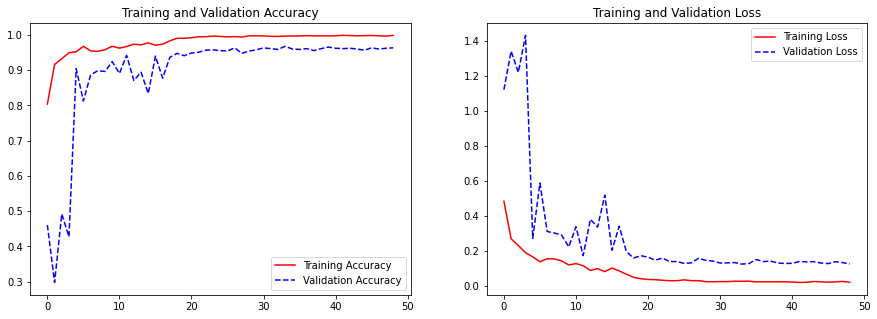

In [ ]:
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [ ]:
score = model.evaluate_generator(test_generator, verbose=1)
print("Prediction accuracy on test data =", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


32/32 [==============================] - 3s 79ms/step - loss: 0.1226 - accuracy: 0.9604
Prediction accuracy on test data = 0.9603960514068604


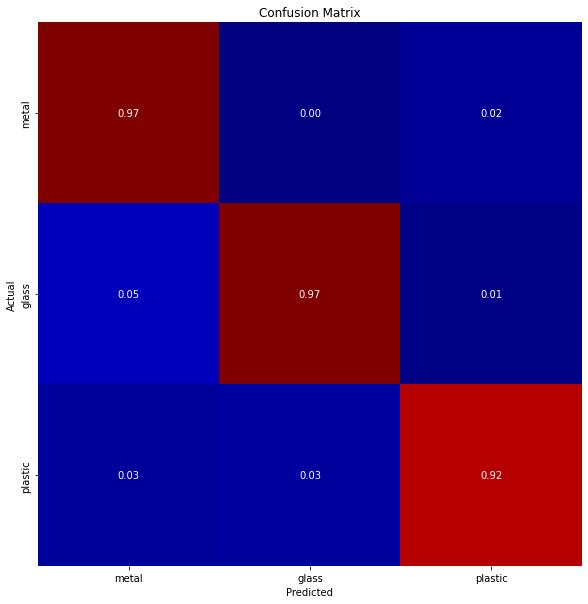

Classification Report:
              precision    recall  f1-score   support

       metal       0.93      0.97      0.95       115
       glass       0.97      0.97      0.97       248
     plastic       0.97      0.92      0.95       133

    accuracy                           0.96       496
   macro avg       0.96      0.96      0.96       496
weighted avg       0.96      0.96      0.96       496



In [ ]:
from sklearn.metrics import *
import seaborn as sns

tick_labels = classes

def showClassficationReport_Generator(model, test_generator, STEP_SIZE_TEST):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_TEST):
        (X,y) = next(test_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=classes))

showClassficationReport_Generator(model, test_generator, STEP_SIZE_TEST)

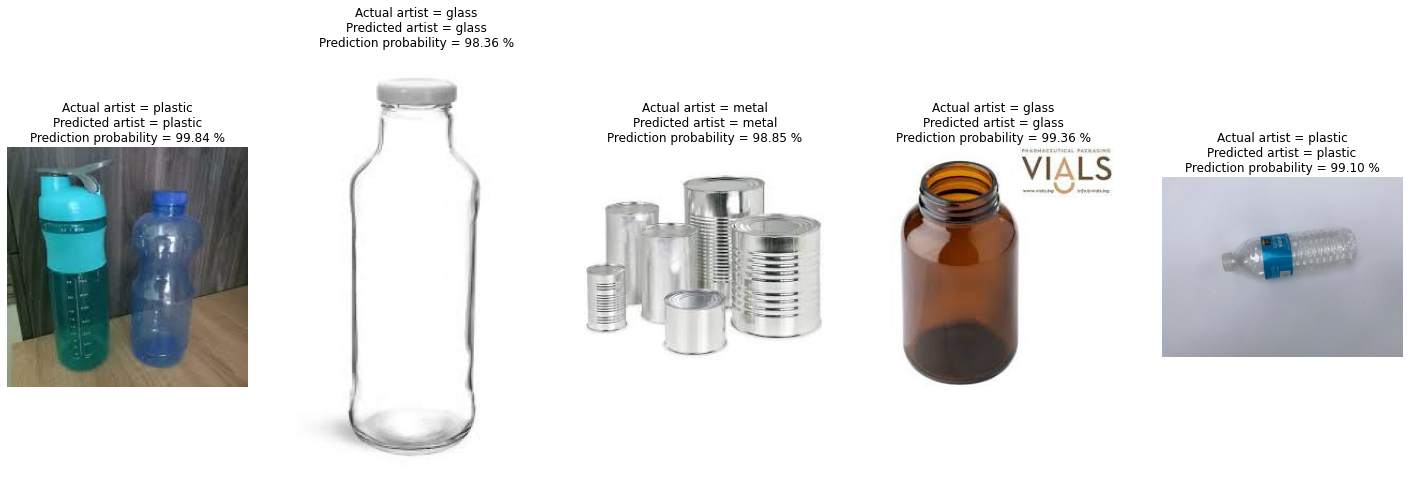

In [ ]:
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_garbage = random.choice(classes)
    random_image = random.choice(os.listdir(os.path.join('/content/test', random_garbage)))
    random_image_file = os.path.join('/content/test', random_garbage, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = test_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_garbage.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

In [ ]:
import imageio
import cv2
def imageFromInternet(url):
    web_image = imageio.imread(url)
    web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
    web_image = image.img_to_array(web_image)
    web_image /= 255.
    web_image = np.expand_dims(web_image, axis=0)

    prediction = model.predict(web_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    print("Prediction probability =", prediction_probability*100, "%")

    plt.imshow(imageio.imread(url))
    plt.axis('off')
    plt.show()


In [ ]:
model.save_weights("ResNet50_GarbageClasses3.h5")

In [ ]:
model.save('ResNet50_GarbageClasses3.model')

INFO:tensorflow:Assets written to: ResNet50_GarbageClasses3.model/assets


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving BTkA52DrZLA.jpg to BTkA52DrZLA.jpg
Saving PF4PZwZil3A.jpg to PF4PZwZil3A.jpg
Saving WGI_vFkM3xQ.jpg to WGI_vFkM3xQ.jpg


Predicted artist = metal
Prediction probability = 96.66821956634521 %


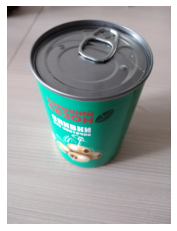

In [ ]:
imageFromInternet('/content/BTkA52DrZLA.jpg')

Predicted artist = metal
Prediction probability = 72.92779088020325 %


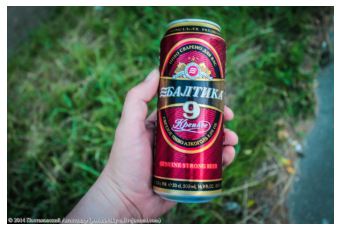

In [ ]:
imageFromInternet('http://ic.pics.livejournal.com/postalovsky_a/32225144/1364714/1364714_900.jpg')

Predicted artist = glass
Prediction probability = 82.07775950431824 %


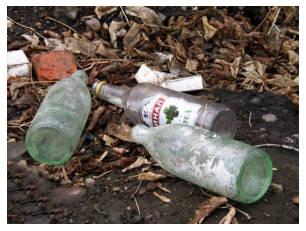

In [ ]:
imageFromInternet('https://sun9-74.userapi.com/impg/QaZ2FZgNESgpZL5mYG8s5e7o62d7UrVHACaf4A/QysCOacejAI.jpg?size=600x447&quality=96&sign=07a6b77906389e4ebf067d12d52f3637&type=album')